<a href="https://colab.research.google.com/github/smhall97/hallucinating_GANs/blob/main/DeepDreamMusic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# @title Imports

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as nd
import torchvision
import torchaudio
import torchaudio.transforms as aT
import torchvision.transforms as vT
from torchvision.transforms import Grayscale
import torchvision.transforms.functional as vF
import torch.optim

import os
import tqdm
import IPython
from IPython.display import display, Audio
import pickle
import random


In [48]:
# Mount Google Drive if Necessary
# from google.colab import drive
# drive.mount('/content/drive') #it will ask you for a verification code

In [49]:
# Set path to datasets and models
datapath = os.path.abspath('./data')
#datapath = os.path.abspath('/content/drive/MyDrive/LEVERHULME/COURSES/NEUROMATCH2021/HallucinatingGANs/Code/data')
print(datapath)

/home/jon/Drive/LEVERHULME/COURSES/NEUROMATCH2021/HallucinatingGANs/Code/data


In [50]:
# @title Helper functions

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

normalize = torchvision.transforms.Normalize(mean, std)
preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize])

def deprocess(image_np):
    image_np = np.transpose(image_np, (1, 2, 0))
    image_np = image_np * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
    #image_np = np.clip(image_np, 0.0, 255.0)
    image_np = np.clip(image_np, 0.0, 1.0)
    return image_np

def clip(image_tensor):
    for c in range(3):
        m, s = mean[c], std[c]
        image_tensor[0, c] = torch.clamp(image_tensor[0, c], -m / s, (1 - m) / s)
    return image_tensor

# @title Set device (GPU or CPU)
# NMA code
# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

def scale_minmax(X):
    mini = X.min()
    maxi = X.max()
    X_scaled = (X - mini) / (maxi - mini)
    return X_scaled, mini, maxi

# Helper Functions for Data Understanding

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()
  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def stat_img(img, origin='upper', gray=False, id=None, autoscale=False, axes=False, stats=True):
    if id is None:
        id = "Image"
    
    if type(img) == Image.Image:
        img = np.array(img)
    elif type(img) == torch.Tensor:
        img = img.numpy()

    if stats:
        print(f"{id}:  {type(img)} of shape {img.shape} and dtype {img.dtype}")
        print(f"{id}:  max: {img.max():.6f}  min: {img.min():.6f}  mean: {img.mean():.6f}  std: {img.std():.6f}")
    
    if not axes:
        plt.axis('off')
    
    if not autoscale:
        vmin, vmax = 0.0, 1.0
        if gray:
            plt.imshow(img, origin=origin, cmap='gray', vmin=vmin, vmax=vmax)
        else:
            plt.imshow(img, origin=origin, vmin=vmin, vmax=vmax)
    else:
        if gray:
            plt.imshow(img, origin=origin, cmap='gray')
        else:
            plt.imshow(img, origin=origin)
    
    plt.show()  

def minmax_scale(arr):
    if type(arr) == torch.Tensor:
        maxi = arr.max().item()
        mini = arr.min().item()
    else: # assume it's a numpy array
        maxi = arr.max()
        mini = arr.min()
        
    return (arr - mini) / (maxi-mini), mini, maxi

def invert_minmax_scale(arr, minimum, maximum):
    return arr * (maximum-minimum) + minimum

def minmax_scale_log(arr):
    return minmax_scale(np.log(arr + 1))

def invert_minmax_scale_log(arr, mini, maxi):
    return np.exp(invert_minmax_scale(arr, mini, maxi))-1


def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None, todb=False):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  if todb:
    spec = librosa.power_to_db(spec)
  im = axs.imshow(spec, origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def play_audio(waveform, samplerate):
  if type(waveform) == torch.Tensor:
      waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(data=waveform, rate=samplerate))
  elif num_channels == 2:
    display(Audio(data=(waveform[0], waveform[1]), rate=samplerate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def stft2wav(spec, n_fft=1024, hop_length=256, sample_rate=22050, win_length=None, plot_wave=False, show_player=True):
    if type(spec) == Image.Image:
        spec = np.array(spec)
    
    resynth_griffin_lim = aT.GriffinLim(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
    )
    print(f"Input image shape {spec.shape}")
    if len(spec.shape) == 2:
        spec = np.expand_dims(spec, 2)
    synthesized_waveform = resynth_griffin_lim(torch.from_numpy(spec).permute(2, 0, 1))
    if plot_wave:
        plot_waveform(synthesized_waveform, sample_rate, title="Synthesized Waveform from STFT")
    if show_player:
        play_audio(synthesized_waveform, sample_rate)
    return synthesized_waveform

def mel2stft(melspec, n_fft=1024, n_mels=128, sample_rate=22050, tolerance_loss=1.0):
    n_stft = int(n_fft/2) + 1

    if type(melspec) == np.ndarray:
        melspec = torch.from_numpy(melspec.astype('float32'))
        
    print(f"Building STFT from Mel Spectrogram (tolerance:{tolerance_loss}) ... This can take a while!")
    resynth_stft = torchaudio.transforms.InverseMelScale(
        n_stft=n_stft, 
        n_mels=n_mels, 
        sample_rate=sample_rate,
        tolerance_loss=tolerance_loss
    )
    result = resynth_stft(melspec)
    print("Done!")
    return result


label2class = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
class2label = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
n_classes = len(class2label)
gztan = None

set_seed(seed=2021)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


# Load model

In [51]:
# Inception3
# See: https://pytorch.org/vision/stable/_modules/torchvision/models/inception.html
# And: https://pytorch.org/hub/pytorch_vision_inception_v3/

# TODO: Test once we have some Inception3 models trained

# state_file = os.path.join(datapath, 'models/inception3.pth')

# inception3 = models.inception_v3(pretrained=False)

# # Add our own classifier layer, replacing the ImageNet classifier on to the end of inception3
# inception3.fc = nn.Sequential(
#     nn.Linear(2048, 256, bias=True),
#     nn.ReLU(), 
#     nn.Linear(256, n_classes, bias=True),                   
#     nn.LogSoftmax(dim=1)
# )

# inception3.load_state_dict(torch.load(model_path))

# Remove the softmax layer
# inception3.fc = inception3.fc[:-1]

# # Freeze the network, we are not training anything in the model
# for param in inception3.parameters():
#     param.requires_grad = False


In [52]:
# VGG16

modelfile = 'models/vgg16_mel_1024_256_128.pt' # VGG16 trained on mel spectrums
state_file = os.path.join(datapath, modelfile)

vgg16 = torchvision.models.vgg16(pretrained=False)

# Add our classifier layer
vgg16.classifier[6] = nn.Sequential(
                      nn.Linear(vgg16.classifier[3].in_features, 256),
                      nn.ReLU(), 
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

vgg16.load_state_dict(torch.load(state_file))

# Remove the softmax layer (we want to optimize the output neurons without softmax)
vgg16.classifier[6] = vgg16.classifier[6][:-1]

# Freeze parameters
for param in vgg16.parameters():
    param.requires_grad = False

vgg16.to(DEVICE) # send to the gpu

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Get input image for dreaming

## 1. GZTAN SPECTROGRAMS

In [53]:
# Pre-existing GZTAN Spectrograms from Each Class
# 10s clips

if gztan is None:
    gztan = torchaudio.datasets.GTZAN(os.path.abspath(datapath), download=False)

sample_rate = 22050
n_fft = 1024
n_mels = 128
win_length = None
hop_length = 256 # smaller hop size leads to better reconstruction but takes longer to compute
power = 2.0 # squared power magnitude spectrogram

wav2stft = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=power,
)

amp2db = torchaudio.transforms.AmplitudeToDB('power')

wav2mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=power,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

waveforms = []
waveformsbyclass = {}
for i in range(0, len(gztan), 100):
    wv, sr, label = gztan[i]
    wv = wv[:,:int(sample_rate * 10)]
    stft = wav2stft(wv).squeeze()
    #stft_db = amp2db(stft)
    mel = wav2mel(wv).squeeze()
    wf = {
        'waveform': wv, 
        'stft': stft, 
        'mel': mel, 
        'samplerate': sr, 
        'label': label,
        'class': label2class[label]
    }
    waveforms.append(wf)
    waveformsbyclass[label] = wf

Mel spec from disk
Image:  <class 'numpy.ndarray'> of shape (128, 2586) and dtype float32
Image:  max: 742.979919  min: 0.000000  mean: 1.236170  std: 6.928416


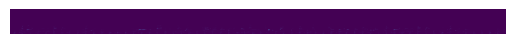

Mel spec from gztan (torchaudio.dataset)
Image:  <class 'numpy.ndarray'> of shape (128, 862) and dtype float32
Image:  max: 402.538544  min: 0.000000  mean: 1.172411  std: 7.227195


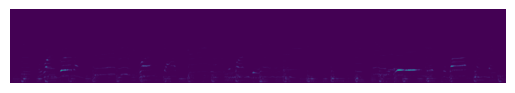

ValueError: operands could not be broadcast together with shapes (128,2586) (128,862) 

In [54]:
# Load a spectrogram from the dataset on disk

spec_path = os.path.join(datapath, 'spectrograms/mel/1024_256_128/blues/blues.00000.pkl')

with open(spec_path, 'rb') as f:
    loaded_spec = pickle.load(f) # load this pickle file, expected a tensor

img = loaded_spec.squeeze(0).cpu().numpy()
#img = np.expand_dims(img, 2)
#print(img.shape, type(img), img.dtype)
#img_disk = np.concatenate((img,img,img), axis=2)
img_disk = img

# Load the same spectrogram from GZTAN to compare
img = waveforms[0]['mel'].cpu().numpy()
#img = np.expand_dims(img, 2)
#print(img.shape, type(img), img.dtype)
#img_gztan = np.concatenate((img,img,img), axis=2)
img_gztan = img

print("Mel spec from disk")
stat_img(img_disk, origin='lower')

print("Mel spec from gztan (torchaudio.dataset)")
stat_img(img_gztan, origin='lower')

print("Difference MSE: ", ((img_disk - img_gztan)**2).mean())

# Scale for dreaming
img_gztan = img_gztan[:, :800] # cut the audio to a small snippet
img_gztan_logscale, mini, maxi = minmax_scale_log(img_gztan)
print(f'mean: {img_gztan_logscale.mean()} min: {img_gztan_logscale.min()} max: {img_gztan_logscale.max()} premin: {mini} premax: {maxi}')

In [11]:
# Reconstruction...

melspec = invert_minmax_scale_log(img_gztan_logscale, mini, maxi) # convert back to original scale
melspec = torch.from_numpy(melspec)
print("Melspec: ", melspec.shape, melspec.dtype, type(melspec))

stft = mel2stft(melspec) # this can take a while to converge...
print("Resulting STFT Audio:", stft.shape)

wav = stft2wav(stft)

Melspec:  torch.Size([128, 800]) torch.float32 <class 'torch.Tensor'>
Building STFT from Mel Spectrogram (tolerance:1.0) ... This can take a while!
Done!
Resulting STFT Audio: torch.Size([513, 800])
Input image shape torch.Size([513, 800])


## 2. Random Noise

Image:  <class 'numpy.ndarray'> of shape (128, 800, 1) and dtype float64
Image:  max: 0.200000  min: 0.000002  mean: 0.100311  std: 0.057717


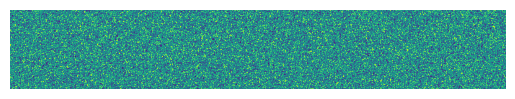

In [113]:
# Dream on noise
noise = np.random.rand(128, 800, 1) / 5.0
stat_img(noise)

## 3. Time-Frequency Patterns

Image:  <class 'numpy.ndarray'> of shape (128, 862) and dtype float64
Image:  max: 0.999998  min: 0.000000  mean: 0.003907  std: 0.054015


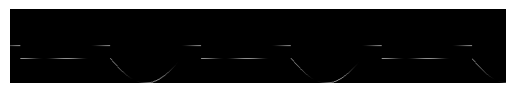





Horizontal Lines, Octave Relationship
Image:  <class 'numpy.ndarray'> of shape (128, 862) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.117188  std: 0.321644


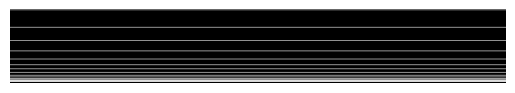





Full Spectrum wave along Time Axis
Image:  <class 'numpy.ndarray'> of shape (128, 862) and dtype float64
Image:  max: 0.999997  min: 0.000005  mean: 0.504453  std: 0.355409


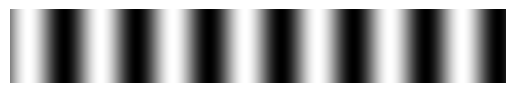

Image:  <class 'numpy.ndarray'> of shape (128, 862) and dtype float64
Image:  max: 1.000000  min: 0.000000  mean: 0.037123  std: 0.189063


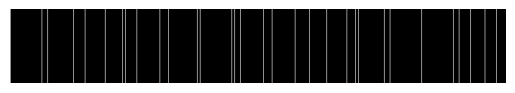

Building STFT from Mel Spectrogram (tolerance:1.0) ... This can take a while!
Done!
Resulting STFT Audio: torch.Size([513, 862])
Input image shape torch.Size([513, 862])


In [55]:
target_dim = (128, 862) # Mel spectrum

# Sinusoidal Pattern
sinus_img = np.zeros(target_dim)
for i in np.arange(0, target_dim[1]):
    idx = int( target_dim[0] * ((np.sin(i * 0.02) + 1)/2))
    val = (np.sin(i * 0.08) + 1)/2
    if idx <= target_dim[0] / 3:
        sinus_img[idx, i] = val
    elif idx < target_dim[0] / 3 * 2:
        sinus_img[int(target_dim[0] / 2), i] = val
    elif idx >= target_dim[0] / 3 * 2:
        sinus_img[int(target_dim[0] / 3), i] = val

stat_img(sinus_img, origin='lower', gray=True)


# Octaves
tone_img = np.zeros(target_dim)
tone_steps = np.geomspace(2, target_dim[0]-1, num=16).astype('int')
for i in np.arange(0, target_dim[1]):
    for j in tone_steps:
        tone_img[j, i] = 1.0
print("\n\n\n\nHorizontal Lines, Octave Relationship")
stat_img(tone_img, origin='lower', gray=True)

# Wave
print("\n\n\n\nFull Spectrum wave along Time Axis")
wave_img = np.zeros(target_dim)
for i in np.arange(0, wave_img.shape[1]):
    val = (np.sin(i * 0.05) + 1)/2
    wave_img[:, i] = val
stat_img(wave_img, origin='lower', gray=True)

# Click / Tone
click_img = np.zeros(target_dim)
clicks1 = np.arange(0, target_dim[1], 200)
clicks2 = np.arange(0, target_dim[1], 65) 
clicks3 = np.arange(0, target_dim[1], 55) 
click_img[:, clicks1] = 1.0
click_img[:, clicks2] = 1.0
click_img[:, clicks3] = 1.0
#for i in np.arange(0, click_img.shape[1]):
stat_img(click_img, origin='lower', gray=True)

stft = mel2stft(tone_img) # this can take a while to converge...
print("Resulting STFT Audio:", stft.shape)
wav = stft2wav(stft)

# Horizontal line fragments

# Stacked Horizontal line fragments

# Dreaming function (without octaves)

In [95]:
# @title Dreaming function

# Expects image to be a numpy array with dimensions HxWx3
# optimizer can be: 'normgrad' 'rawgrad'
# loss_type can be: 'unit' 'unitdifference'
def dream(image, model, iterations, dream_stepsize, unit=0, unit2=None, loss_type='unit', optimizer='normgrad',
          sched_stepsize=None, sched_gamma=0.8, report_interval=5):
    """ Updates the image to maximize output unit for n iterations """
    
    if loss_type == 'unitdifference':
        if unit2 is None:
            print(f"Dream of {class2label[unit]} against all ... {image.shape}")
        else:
            print(f"Dream of {class2label[unit]} against {class2label[unit2]} ... {image.shape}")
    elif loss_type == 'unit':
        print(f"Dream of {class2label[unit]} ... {image.shape}")

    image = preprocess(image)
    
    # Convert the numpy array image into a requires_grad=True Tensor that we will optimize
    image = torch.tensor(image, requires_grad=True, dtype=torch.float, device=DEVICE)


    if sched_stepsize is None:
        sched_stepsize = report_interval
    
    lr_st = dream_stepsize
    best_dream = image.detach().cpu().data.numpy()
    best_loss = 0
    best_activations = None
    best_activation = None
    
    out = None
    activations = None
    loss = None
    
    # Optimization loop
    for i in range(iterations):
        # Learning without optimizer
        
        model.zero_grad()
        out = model(image.unsqueeze(0))
        activations = out[0]
        if loss_type == 'unit':
            loss = activations[unit] # maximize this unit
        elif loss_type == 'unitdifference':
            if unit2 is None:
                # Maximize the difference between the selected genre and all other genres
                other_idxs = torch.arange(0, len(activations)) != unit
                loss = activations[unit] - activations[other_idxs].sum() # maximize this difference
            else:
                # Maximize the difference between the selected genre and another genre
                loss = activations[unit] - activations[unit2]
            
        if loss.item() > best_loss:
            best_loss = loss.detach().cpu().item()
            best_activations = activations.detach().cpu().data.numpy()
            best_activation = best_activations[unit]
            best_dream = image.detach().cpu().data.numpy()
                        
        loss.backward()

        # Try and maximize the loss by updating the image (Gradient Ascent)
        with torch.no_grad():
            # TODO: try normalizing gradients
            # See: https://www.tensorflow.org/tutorials/generative/deepdream
            
            if optimizer == 'normgrad':
                # Optimization Method #1            
                absgrad = torch.abs(image.grad)
                norm_step = dream_stepsize / absgrad.mean()
                image += norm_step * image.grad
                image = clip(image) # TODO: try scaling instead of clipping
            elif optimizer == 'rawgrad':
                # Optimization Method #2 (uses negative gradients to inhibit some pixels)
                image += dream_stepsize * image.grad * 100 # step size needs to be much larger for this method!            
                image = clip(image) # TODO: try scaling instead of clipping        
                
        
        if i % report_interval == 0:
            acts = activations.detach().cpu().data.numpy()
            res = ""
            for idx, val in enumerate(acts):
                res += f' {class2label[idx]}: {val:.3f} '
            print("------------------------------------------")
            if loss_type == 'unitdifference' and not unit2 is None:
                print(f"Iter {i}: {class2label[unit]}: {acts[unit]:.3f} vs {class2label[unit2]}: {acts[unit2]:.3f} ")
            else:
                print(f"Iter {i}: {class2label[unit]}: {acts[unit]:.3f}")
            print(f'  loss: {loss.detach().cpu().item()}   stepsize: {dream_stepsize:.6f}')
            print(f"  {res}")
            stat_img(deprocess(best_dream), origin='lower', stats=False, gray=True)
       
        # Step the learning rate
        if (i+1) % sched_stepsize == 0:
            dream_stepsize = dream_stepsize * sched_gamma
        
        image.grad.zero_()
        
        del out
        del activations
        del loss
    
    print('---------------------------------')
    if loss_type == 'unit':
        print(f"Done dreaming of {class2label[unit]} ... ")
    elif loss_type == 'unitdifference':
        if unit2 is None:
            print(f"Done dreaming of {class2label[unit]} vs all ... ")
        else:
            print(f"Done dreaming of {class2label[unit]} vs {class2label[unit2]}  ... ")

    print(f'best loss: {best_loss:.3f}   best activation: {best_activation:.3f}')
    print(f'loss: {loss_type}  optimizer: {optimizer}  iterations: {iterations}  lr_st: {lr_st:.4f}   lr_end: {dream_stepsize:.5f}')
    res = ""
    for idx, val in enumerate(best_activations):
        res += f' {class2label[idx]}: {val:.3f} '
    print(f"best activations: {res}")
    stat_img(deprocess(best_dream), origin='lower', stats=False)
    
    return deprocess(best_dream)

### Dreaming hyperparameters and input image

In [102]:
# Load image to be dreamed:
#image = sinus_img
#image = wave_img
image = click_img
#image = tone_img
#image = noise
#image = waveformsbyclass['blues']['mel']
#image = waveformsbyclass['rock']['mel']
#image = waveformsbyclass['classical']['mel']

# genre of interest
contrast_unit = None

#dreaming_unit = label2class['disco']
dreaming_unit = label2class['reggae']


# Copy across RGB channels
image = np.expand_dims(image, 2)
image = np.concatenate((image, image, image), axis=2)

# Model to use
trained_model = vgg16

# Hyper parameters for deep dreaming
learning_rate = 1e-02
iterations = 50 # number of times the deep dream loop should be run

learning_rate = 5e-02
iterations = 3000

learning_rate = 1e-01
optimizer = 'normgrad'
loss_type = 'unit'
iterations = 400
scheduler_stepsize=50
scheduler_gamma=0.5


learning_rate = 1e-00
optimizer = 'rawgrad'
loss_type = 'unitdifference'
iterations = 400
scheduler_stepsize=25
scheduler_gamma=0.5

learning_rate = 1e-01
optimizer = 'normgrad'
loss_type = 'unitdifference'
iterations = 400
scheduler_stepsize=25
scheduler_gamma=0.5
contrast_unit = label2class['disco']

# learning_rate = 1e-00
# optimizer = 'rawgrad'
# loss_type = 'unitdifference'
# iterations = 400
# scheduler_stepsize=25
# scheduler_gamma=0.5
# contrast_unit = label2class['disco']



### Run the dreaming function

Dream of reggae against disco ... (128, 862, 3)
------------------------------------------
Iter 0: reggae: -0.381 vs disco: 0.091 
  loss: -0.4717920124530792   stepsize: 0.100000
   blues: 0.119  classical: -0.299  country: -0.614  disco: 0.091  hiphop: 1.207  jazz: -1.986  metal: -0.112  pop: 0.298  reggae: -0.381  rock: 1.191 


<ipython-input-95-2ca6cbdf11c0>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True, dtype=torch.float, device=DEVICE)


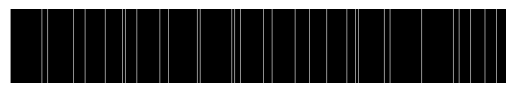

------------------------------------------
Iter 20: reggae: 35.629 vs disco: -2.077 
  loss: 37.705528259277344   stepsize: 0.100000
   blues: 9.144  classical: -25.406  country: 1.706  disco: -2.077  hiphop: 7.651  jazz: 0.819  metal: -14.986  pop: 16.153  reggae: 35.629  rock: 0.463 


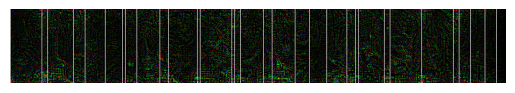

------------------------------------------
Iter 40: reggae: 130.644 vs disco: -27.926 
  loss: 158.57037353515625   stepsize: 0.050000
   blues: 24.285  classical: -85.562  country: 6.638  disco: -27.926  hiphop: 12.006  jazz: 12.642  metal: -66.993  pop: 50.284  reggae: 130.644  rock: -15.012 


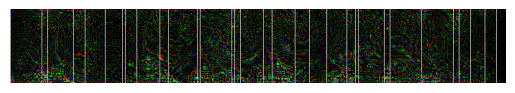

------------------------------------------
Iter 60: reggae: 148.813 vs disco: -62.207 
  loss: 211.01976013183594   stepsize: 0.025000
   blues: 28.122  classical: -128.604  country: -15.466  disco: -62.207  hiphop: 22.855  jazz: -3.456  metal: -50.868  pop: 60.147  reggae: 148.813  rock: 5.684 


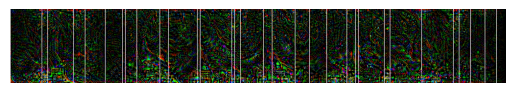

------------------------------------------
Iter 80: reggae: 224.715 vs disco: -32.052 
  loss: 256.76678466796875   stepsize: 0.012500
   blues: 46.730  classical: -162.429  country: -28.175  disco: -32.052  hiphop: 45.862  jazz: -24.473  metal: -86.561  pop: 93.515  reggae: 224.715  rock: 42.083 


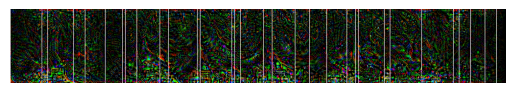

------------------------------------------
Iter 100: reggae: 281.052 vs disco: -63.355 
  loss: 344.40704345703125   stepsize: 0.006250
   blues: 67.462  classical: -179.456  country: -21.300  disco: -63.355  hiphop: -20.791  jazz: 3.399  metal: -115.310  pop: 109.361  reggae: 281.052  rock: 16.761 


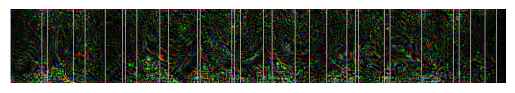

------------------------------------------
Iter 120: reggae: 219.411 vs disco: 7.806 
  loss: 211.60462951660156   stepsize: 0.006250
   blues: 70.910  classical: -152.320  country: -35.384  disco: 7.806  hiphop: 14.875  jazz: 21.578  metal: -93.953  pop: 55.671  reggae: 219.411  rock: -12.671 


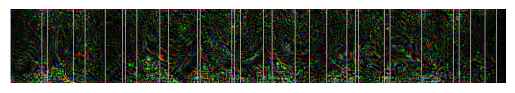

------------------------------------------
Iter 140: reggae: 207.555 vs disco: -42.691 
  loss: 250.24575805664062   stepsize: 0.003125
   blues: 37.916  classical: -130.544  country: -9.790  disco: -42.691  hiphop: 35.148  jazz: 11.841  metal: -86.155  pop: 96.663  reggae: 207.555  rock: 0.986 


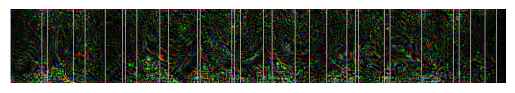

------------------------------------------
Iter 160: reggae: 233.895 vs disco: -60.004 
  loss: 293.8997497558594   stepsize: 0.001563
   blues: 59.528  classical: -176.364  country: -53.292  disco: -60.004  hiphop: 81.783  jazz: -14.396  metal: -72.081  pop: 112.179  reggae: 233.895  rock: 16.857 


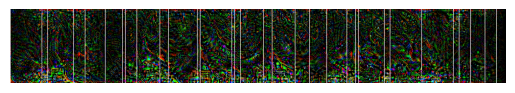

------------------------------------------
Iter 180: reggae: 256.377 vs disco: -73.631 
  loss: 330.0073547363281   stepsize: 0.000781
   blues: 79.140  classical: -209.511  country: 12.685  disco: -73.631  hiphop: 5.854  jazz: 16.682  metal: -120.040  pop: 101.299  reggae: 256.377  rock: 26.691 


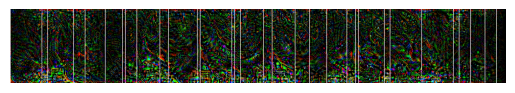

------------------------------------------
Iter 200: reggae: 200.423 vs disco: -53.641 
  loss: 254.0638885498047   stepsize: 0.000391
   blues: 36.289  classical: -135.029  country: -23.061  disco: -53.641  hiphop: 7.386  jazz: 26.874  metal: -118.572  pop: 80.219  reggae: 200.423  rock: 19.773 


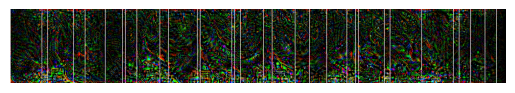

------------------------------------------
Iter 220: reggae: 306.263 vs disco: -69.960 
  loss: 376.22369384765625   stepsize: 0.000391
   blues: 76.110  classical: -184.452  country: -39.090  disco: -69.960  hiphop: 29.613  jazz: -15.149  metal: -99.393  pop: 106.106  reggae: 306.263  rock: -1.695 


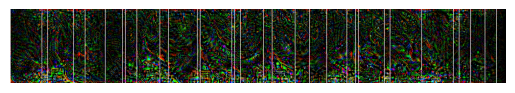

------------------------------------------
Iter 240: reggae: 210.241 vs disco: -53.781 
  loss: 264.0218200683594   stepsize: 0.000195
   blues: 48.394  classical: -144.416  country: -27.283  disco: -53.781  hiphop: 53.663  jazz: -3.006  metal: -71.693  pop: 86.178  reggae: 210.241  rock: -2.271 


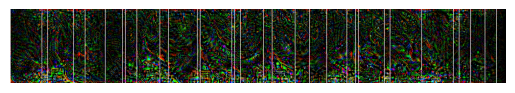

------------------------------------------
Iter 260: reggae: 246.115 vs disco: -59.258 
  loss: 305.3724060058594   stepsize: 0.000098
   blues: 47.637  classical: -178.511  country: -40.561  disco: -59.258  hiphop: 69.533  jazz: -25.988  metal: -79.314  pop: 118.009  reggae: 246.115  rock: 21.985 


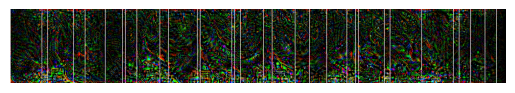

------------------------------------------
Iter 280: reggae: 208.325 vs disco: -48.744 
  loss: 257.06939697265625   stepsize: 0.000049
   blues: 47.889  classical: -138.194  country: -15.423  disco: -48.744  hiphop: 11.762  jazz: 41.732  metal: -107.597  pop: 98.525  reggae: 208.325  rock: 10.086 


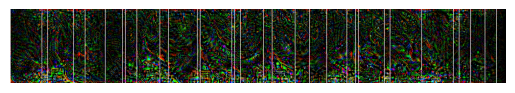

------------------------------------------
Iter 300: reggae: 248.406 vs disco: -25.027 
  loss: 273.4332580566406   stepsize: 0.000024
   blues: 71.260  classical: -224.998  country: -25.407  disco: -25.027  hiphop: 62.041  jazz: -9.363  metal: -93.759  pop: 96.146  reggae: 248.406  rock: -2.365 


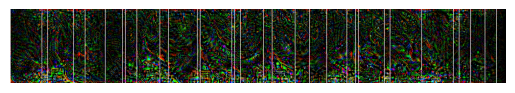

------------------------------------------
Iter 320: reggae: 246.782 vs disco: -35.697 
  loss: 282.47808837890625   stepsize: 0.000024
   blues: 17.600  classical: -157.461  country: 1.350  disco: -35.697  hiphop: 61.679  jazz: -19.521  metal: -110.453  pop: 88.886  reggae: 246.782  rock: -11.029 


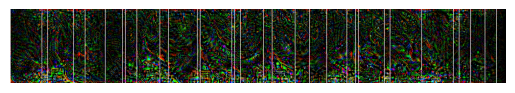

------------------------------------------
Iter 340: reggae: 243.250 vs disco: -34.244 
  loss: 277.4942626953125   stepsize: 0.000012
   blues: 42.975  classical: -201.101  country: -8.021  disco: -34.244  hiphop: 36.627  jazz: 4.847  metal: -88.948  pop: 105.576  reggae: 243.250  rock: 16.617 


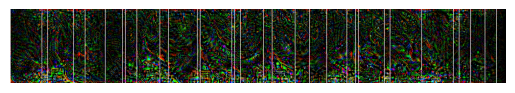

------------------------------------------
Iter 360: reggae: 226.460 vs disco: -78.131 
  loss: 304.59124755859375   stepsize: 0.000006
   blues: 55.627  classical: -160.475  country: -6.307  disco: -78.131  hiphop: 52.080  jazz: -13.912  metal: -92.820  pop: 91.776  reggae: 226.460  rock: 6.489 


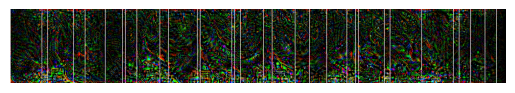

------------------------------------------
Iter 380: reggae: 256.588 vs disco: -69.465 
  loss: 326.0534362792969   stepsize: 0.000003
   blues: 63.444  classical: -121.995  country: -13.906  disco: -69.465  hiphop: 53.491  jazz: 0.415  metal: -132.710  pop: 75.934  reggae: 256.588  rock: -36.296 


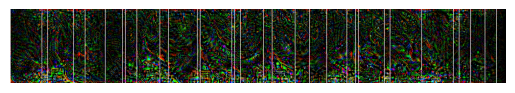

---------------------------------
Done dreaming of reggae vs disco  ... 
best loss: 411.408   best activation: 349.911
loss: unitdifference  optimizer: normgrad  iterations: 400  lr_st: 0.1000   lr_end: 0.00000
best activations:  blues: 64.339  classical: -240.678  country: -21.767  disco: -61.497  hiphop: 31.849  jazz: 48.324  metal: -175.313  pop: 130.820  reggae: 349.911  rock: 19.150 


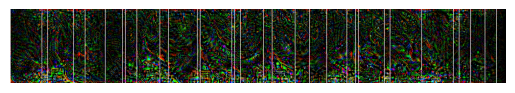

In [103]:
ri = int(iterations / 20)
original_image = image
dreamed_image = dream(
    image=image, 
    model=trained_model, 
    iterations=iterations, 
    dream_stepsize=learning_rate, 
    unit=dreaming_unit, 
    unit2=contrast_unit,
    loss_type=loss_type,
    optimizer=optimizer,
    sched_stepsize=scheduler_stepsize,
    sched_gamma=scheduler_gamma,
    report_interval=ri,
)

Original:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Original:  max: 1.000000  min: 0.000000  mean: 0.037123  std: 0.189063


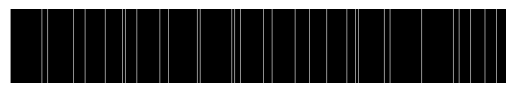

Dreamed:  <class 'numpy.ndarray'> of shape (128, 862, 3) and dtype float64
Dreamed:  max: 1.000000  min: 0.000000  mean: 0.133988  std: 0.237265


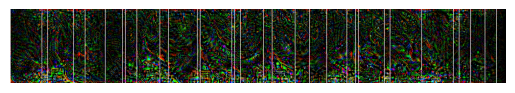

Difference MSE:  0.04098461398311579


In [104]:
stat_img(original_image, origin='lower', id='Original')
stat_img(dreamed_image, origin='lower', id='Dreamed')
print("Difference MSE: ", ((dreamed_image - original_image)**2).mean())

In [105]:
# Optional, invert log scale
#invert_log_scale = True
invert_log_scale = False

Building STFT from Mel Spectrogram (tolerance:1.0) ... This can take a while!
Done!
Building STFT from Mel Spectrogram (tolerance:1.0) ... This can take a while!
Done!
Building STFT from Mel Spectrogram (tolerance:1.0) ... This can take a while!
Done!
Resulting STFT Audio: torch.Size([513, 862])
Red
Image:  <class 'torch.Tensor'> of shape torch.Size([128, 862]) and dtype torch.float32
Image:  max: 1.000000  min: 0.000000  mean: 0.135517  std: 0.238740


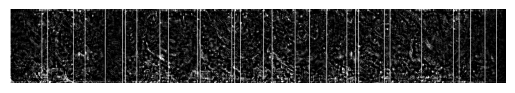

Input image shape torch.Size([513, 862])


Green
Image:  <class 'torch.Tensor'> of shape torch.Size([128, 862]) and dtype torch.float32
Image:  max: 1.000000  min: 0.000000  mean: 0.157240  std: 0.252743


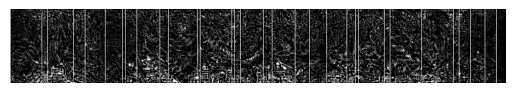

Input image shape torch.Size([513, 862])


Blue
Image:  <class 'torch.Tensor'> of shape torch.Size([128, 862]) and dtype torch.float32
Image:  max: 1.000000  min: 0.000000  mean: 0.109206  std: 0.216456


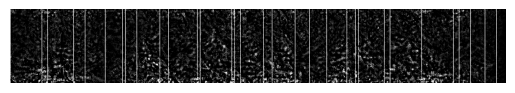

Input image shape torch.Size([513, 862])


In [106]:
# Reconstruction: MEL

modelname = 'vgg16_params'

output_filename = f''

mel_tolerance = 1.0
melspec = torch.from_numpy(dreamed_image.astype('float32'))
melR = melspec[:,:,0]
melG = melspec[:,:,1]
melB = melspec[:,:,2]

if invert_log_scale:
    melR = invert_minmax_scale_log(melR, mini, maxi)
    melG = invert_minmax_scale_log(melR, mini, maxi)
    melB = invert_minmax_scale_log(melR, mini, maxi)

stftR = mel2stft(melR, tolerance_loss=mel_tolerance) # this can take a while to converge...
stftG = mel2stft(melG, tolerance_loss=mel_tolerance) # this can take a while to converge...
stftB = mel2stft(melB, tolerance_loss=mel_tolerance) # this can take a while to converge...
print("Resulting STFT Audio:", stftR.shape)
print("Red")
stat_img(melR, origin='lower', gray=True)
wavR = stft2wav(stftR)
print("Green")
stat_img(melG, origin='lower', gray=True)
wavG = stft2wav(stftG)
print("Blue")
stat_img(melB, origin='lower', gray=True)
wavB = stft2wav(stftB)

# Save results?

In [40]:
melspec = invert_minmax_scale_log(dreamed_image.astype('float32'), mini, maxi) # convert back to original scale
print("Difference MSE: ", ((melspec - img_gztan[:,:800,:])**2).mean())
melspec = torch.from_numpy(melspec[:,:,0]) # Get just one channel
print("Melspec: ", melspec.shape, melspec.dtype)
stft = mel2stft(melspec) # this can take a while to converge...
print("Resulting STFT Audio:", stft.shape)
wav = stft2wav(stft)

Difference MSE:  59.400803
Melspec:  torch.Size([128, 800]) torch.float32
Resulting STFT Audio: torch.Size([513, 800])
Input image shape torch.Size([513, 800])
